In [81]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
import cv2

POSTER_FOLDER = "../data/raw/images"
POSTER_SHAPE = (900, 600, 3)
PLOT_FOLDER = "../data/raw/plots/poster_analysis"

Total sum: 172283604
{'r': 48418103, 'g': 62001552, 'b': 61863949}
{'r': 0.2810372076962123, 'g': 0.35988074639998824, 'b': 0.3590820459037994}
dominant_color_values (540000,)
dominant_color_mean 114.8176888888889
Total sum: 161935510
{'r': 48213541, 'g': 45725397, 'b': 67996572}
{'r': 0.2977329740709743, 'g': 0.2823679438808696, 'b': 0.41989908204815607}
dominant_color_values (540000,)
dominant_color_mean 125.91957777777777
Total sum: 77463623
{'r': 27635928, 'g': 24392775, 'b': 25434920}
{'r': 0.3567600756293054, 'g': 0.3148932886859681, 'b': 0.3283466356847265}
dominant_color_values (540000,)
dominant_color_mean 51.17764444444445
Total sum: 120536892
{'r': 43546588, 'g': 40467779, 'b': 36522525}
{'r': 0.36127186687375346, 'g': 0.33572940473693313, 'b': 0.30299872838931335}
dominant_color_values (540000,)
dominant_color_mean 80.64182962962963
Total sum: 119725380
{'r': 51145939, 'g': 34191046, 'b': 34388395}
{'r': 0.4271937913247801, 'g': 0.28557893071627755, 'b': 0.2872272779589424}

KeyboardInterrupt: 

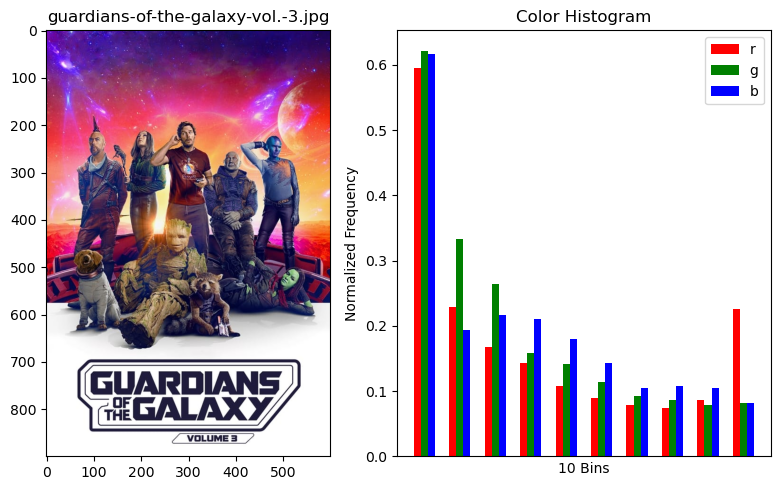

In [115]:
movie_dominant_colors = []

for file in os.listdir(POSTER_FOLDER):
    # print(file)
    # load image into numpy array
    
    image = plt.imread(os.path.join(POSTER_FOLDER, file))
    # print(file, image.shape)
    if image.shape != POSTER_SHAPE:
        sys.exit(1)

    # make plots beside each other
    # ax = plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)

    plt.title(file)

    plt.imshow(image)
    # plt.show()

    # get color histogram
    colors = ('r', 'g', 'b')
    
    # color_occourances = {"r": [], "g": [], "b": []}
    
    width = 0.2
    for i, col in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        # print(hist.shape)
        # color_hist = hist.flatten()
        # color_occourances[col] 

        # convert to bar plot of 10 bins
        hist = np.array([sum(hist[i * 25 : (i + 1) * 25]) for i in range(10)])
        # print(hist.shape)
        # normalize
        hist = hist / sum(hist)
        # flatten array
        hist = hist.flatten()
        indexes = np.arange(10)
        indexes  = indexes + (i * width)
        # print(indexes)
        # plot
        plt.subplot(1, 2, 2)
        plt.bar(indexes, hist, width=width, color=col)
        plt.title("Color Histogram")
        plt.xlabel("10 Bins")
        plt.ylabel("Normalized Frequency")
        # xticks are ranges of 25
        plt.xticks(np.arange(10), np.arange(10) * 25)
        # dont show x ticks
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        # y ticks are percentages
        plt.legend(colors)
        plt.tight_layout()
    
    # make plot wider
    

    # print("number of red colors:", sum(color_occourances["r"]))
    # print("number of green colors:", sum(color_occourances["g"]))
    # print("number of blue colors:", sum(color_occourances["b"]))

    # print(color_occourances["r"])

    np_img = np.array(image)

    # print(np_img.shape)

    # sum all different colors so that we get a total sum of all colors for the image

    
    color_occourances = {
        "r": np_img[:, :, 0].flatten(),
        "g": np_img[:, :, 1].flatten(),
        "b": np_img[:, :, 2].flatten()
    }

    # sum all red colors
    color_sums = {
        "r": sum(color_occourances["r"]),
        "g": sum(color_occourances["g"]),
        "b": sum(color_occourances["b"])
    }

    total_sum = sum(color_sums.values())
    print("Total sum:", total_sum)

    print(color_sums)

    color_sum_percentage = {
        "r": color_sums["r"] / total_sum,
        "g": color_sums["g"] / total_sum,
        "b": color_sums["b"] / total_sum
    }
    print(color_sum_percentage)

    dominant_color_index = max(color_sum_percentage, key=color_sum_percentage.get)

    dominant_color_values = color_occourances[dominant_color_index]
    print("dominant_color_values", dominant_color_values.shape)
    
    dominant_color_mean = np.mean(dominant_color_values)

    print("dominant_color_mean", dominant_color_mean)

    plt.title(f"Dominant color is {dominant_color_index.replace('r', 'red').replace('g', 'green').replace('b', 'blue')}")


    movie_dominant_colors.append((file, dominant_color_index, dominant_color_mean))

    plt.gcf().set_size_inches(8, 5)
    plt.savefig(f"{PLOT_FOLDER}/RGB_{file}")
    plt.show()